In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Poisson Equations

<font  face=Times color=darkblue size=3> In this notebook, we discuss computational methods to solve Poisson equation: $$\Delta \phi (\vec x_{\vec r})=-\frac{1}{\epsilon_0}\rho(\vec x_{\vec r}).$$ After discretization through the centered three-point formula in each direction, it has a form: $$\phi (\vec x_{\vec r})=\frac{1}{2d}\sum_1^d[\phi (\vec x_{\vec r+h\vec e_i})+\phi (\vec x_{\vec r-h\vec e_i})]+\frac{h^2}{2d\epsilon_0}\rho(\vec x_{\vec r}).$$
    For simplicity, we set the time spacing $h=1$, $\epsilon_0=1$ and we consider $N\times N$ two-dimensional cases($d=2$ and including the boundary) with the initial condition and charge density defined as below. We use Dirichlet boundary conditions: $\phi(\vec{x}_\vec{r}) =0$ for $\vec{x}_\vec{r}\in \partial V$.

In [2]:
### you can change the initial conditions in this cell for all methods below, including N and the charge_density

N=30 #2 of N are boundaries
d=2
epsilon=1
h=1
#initial condition
potential_initial=np.zeros((N,N)) #this includes boundary=0
charge_density=np.ones((N,N))   #uniform distribution for introduction of the methods

## Jacobi Relaxation

<font  face=Times color=darkblue size=3> We use the discretized formula to iteratively compute new $\phi$ and replace the old values by new ones until $\delta \phi={\rm max}_{\vec r}|\phi^{\rm new}(\vec x_{\vec r})-\phi(\vec x_{\vec r})|$ is no larger than the specified bound which is defined below.

In [3]:
def jacobi_relaxation(bound_jr):
    iterations=0
    potential_here=copy.deepcopy(potential_initial)
    while True:
        iterations+=1
        potential_new=copy.deepcopy(potential_here)  #set phi_new
        for i in range(1,N-1):
            for j in range(1,N-1): # simulate all N-2*N-2 sites using discretized poisson equation, no simulation for boundary 
                left_index=i-h
                right_index=i+h
                up_index=j+h
                down_index=j-h
                potential_new[i,j]=(1/(2*d))*(potential_here[i,up_index]+potential_here[i,down_index]+potential_here[right_index,j]
                                              +potential_here[left_index,j])+(h**2/(2*d*epsilon))*charge_density[i,j] 
        max_delta=np.max(np.abs(potential_new-potential_here)) # compute delta_phi
        if max_delta <= bound_jr:
            break
        else:
            potential_here=copy.deepcopy(potential_new)
        #print(iterations,max_delta)
    return iterations,potential_new

In [4]:
iterations_jr,potential_jr=jacobi_relaxation(0.0001)

In [5]:
iterations_jr #iterations_needed

1414

In [6]:
potential_jr[0:N,0:N]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.96119782,  3.42239795,  4.58122979,  5.53057683,
         6.32118121,  6.98415783,  7.54021951,  8.00394385,  8.38596137,
         8.69417363,  8.93447486,  9.11119792,  9.2273961 ,  9.28501966,
         9.28501966,  9.2273961 ,  9.11119792,  8.93447486,  8.69417363,
         8.38596137,  8.00394385,  7.54021951,  6.98415783,  6.32118121,
         5.53057683,  4.58122979,  3.42239795,  1.96119782,  0.        ],
       [ 0.        ,  3.42239795,  6.14717342,  8.37195806, 10.21991435,
        11.77001229, 13.07525657, 14.17280584, 15

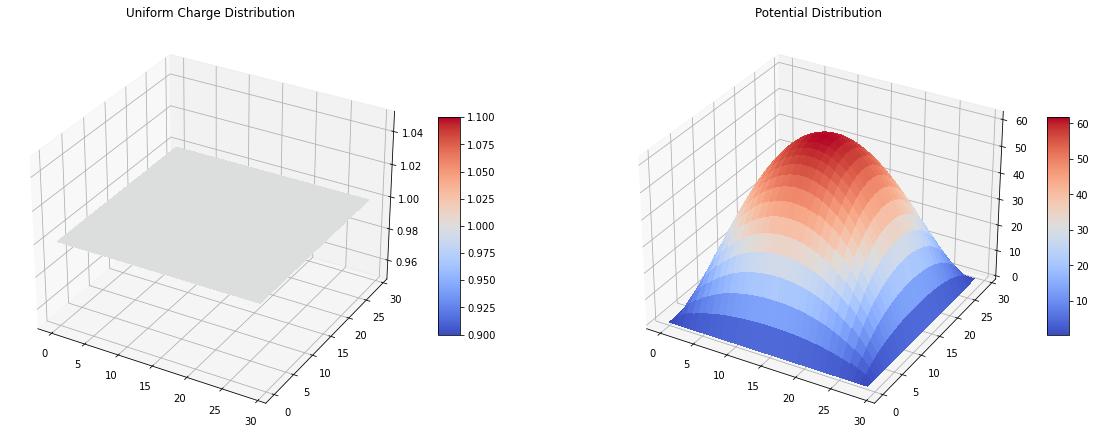

In [7]:
from matplotlib import cm
fig_jr=plt.figure(figsize=(20,8))
ax1_jr = fig_jr.add_subplot(1, 2, 1, projection='3d')
X1 = np.arange(0,N)
Y1 = np.arange(0,N)
X1, Y1 = np.meshgrid(X1, Y1)
Z1_jr = charge_density[0:N,0:N]
surf1_jr = ax1_jr.plot_surface(X1, Y1, Z1_jr, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1_jr.set_title('Uniform Charge Distribution')
fig_jr.colorbar(surf1_jr, shrink=0.5, aspect=10)

ax3_jr = fig_jr.add_subplot(1, 2, 2, projection='3d')
Z3_jr = potential_jr[0:N,0:N]
surf3_jr = ax3_jr.plot_surface(X1, Y1, Z3_jr, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3_jr.set_title('Potential Distribution')
fig_jr.colorbar(surf3_jr, shrink=0.5, aspect=10)


## Gauss-Seidel Relaxation

<font  face=Times color=darkblue size=3> In Jacobi Relaxation, we need to store two arrays of potential, including the new and old ones. A simple modification is made here, that is, we update every lattice point which results a lattice with both old and new points. We not only saves memory but will also cut the iterations apporximately in half.

In [8]:
def gauss_seidel_relaxation(bound_here):
    iterations=0
    potential_new=copy.deepcopy(potential_initial)
    while True:
        iterations+=1
        max_delta=0
        for i in range(1,N-1):
            for j in range(1,N-1): # simulate all N-2*N-2 sites using discretized poisson equation, no simulation for boundary 
                left_index=i-h
                right_index=i+h
                up_index=j+h
                down_index=j-h
                potential_point_new=(1/(2*d))*(potential_new[i,up_index]+potential_new[i,down_index]+potential_new[right_index,j]
                                              +potential_new[left_index,j])+(h**2/(2*d*epsilon))*charge_density[i,j] #new point
                max_delta=max(max_delta,np.abs(potential_new[i,j]-potential_point_new))  #delta_phi
                potential_new[i,j]=potential_point_new #update point
        if max_delta <= bound_here:
            break
        #print(iterations,max_delta)
    return iterations,potential_new

In [9]:
iterations_gs,potential_gs=gauss_seidel_relaxation(0.0001)

In [10]:
iterations_gs

767

In [11]:
potential_gs[0:N,0:N]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.96128063,  3.42256396,  4.58147834,  5.53090627,
         6.32158886,  6.98464004,  7.54077163,  8.00456035,  8.38663582,
         8.69489883,  8.93524286,  9.11200017,  9.2282235 ,  9.28586267,
         9.28586844,  9.22824059,  9.112028  ,  8.93528042,  8.69494476,
         8.38668841,  8.00461759,  7.54083123,  6.98469948,  6.32164547,
         5.53095723,  4.58152079,  3.42259503,  1.96129751,  0.        ],
       [ 0.        ,  3.42256396,  6.14750614,  8.37245617, 10.22057448,
        11.77082906, 13.07622261, 14.17391185, 15

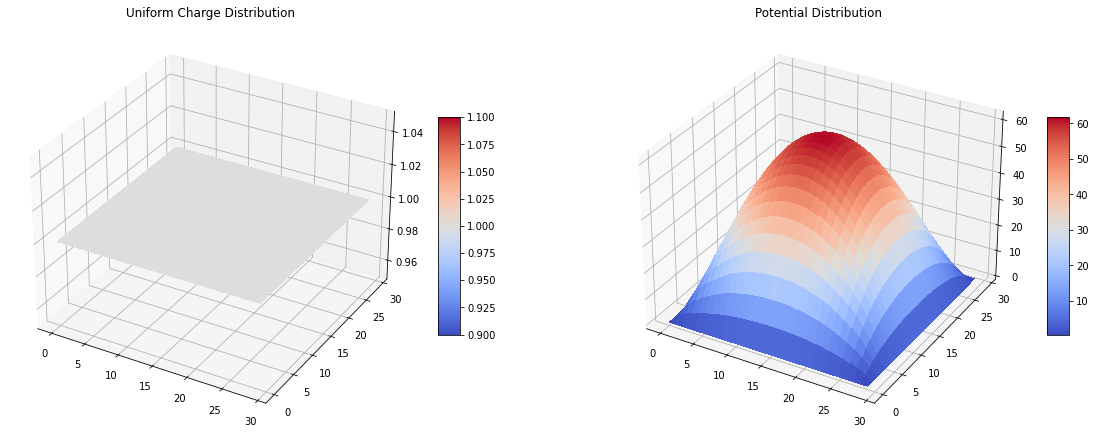

In [12]:
fig_gs=plt.figure(figsize=(20,8))
ax1_gs = fig_gs.add_subplot(1, 2, 1, projection='3d')
X1 = np.arange(0,N)
Y1 = np.arange(0,N)
X1, Y1 = np.meshgrid(X1, Y1)
Z1_gs = charge_density[0:N,0:N]
surf1_gs = ax1_gs.plot_surface(X1, Y1, Z1_gs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1_gs.set_title('Uniform Charge Distribution')
fig_gs.colorbar(surf1_gs, shrink=0.5, aspect=10)

ax3_gs = fig_gs.add_subplot(1, 2, 2, projection='3d')
Z3_gs = potential_gs[0:N,0:N]
surf3_gs = ax3_gs.plot_surface(X1, Y1, Z3_gs, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3_gs.set_title('Potential Distribution')
fig_gs.colorbar(surf3_gs, shrink=0.5, aspect=10)

## Successive Overrelaxation (SOR)

<font  face=Times color=darkblue size=3> To further fasten the Gauss-Seidel relaxation, we modify the update step as follows: $$\phi (\vec x_{\vec r})\rightarrow (1-w)\phi (\vec x_{\vec r})+w[ \frac{1}{2d}\sum_1^d[\phi (\vec x_{\vec r+h\vec e_i})+\phi (\vec x_{\vec r-h\vec e_i})]+\frac{h^2}{2d\epsilon_0}\rho(\vec x_{\vec r})].$$ A relaxation parameter $w$ is introduced, and the Gauss Seidel corresponds to $w=1$. We now try to use an overrelaxation parameter $w>1$ and this method is only stable for $w<2$. In particular, there is an optimal value $w_{\rm opt}$. In the case of a $N_x \times N_y$ ($N_x=N_y=N-2$) lattice with Dirichlet boundary conditions, $$w_{\rm opt}=\frac{2}{1+\sqrt{1-r^2}},\ r=0.5(\cos{(\pi/N_x)}+\cos{(\pi/N_y)}).$$

In [13]:
def sor(bound_here):
    iterations=0
    potential_new=copy.deepcopy(potential_initial)
    rhere=np.cos(np.pi/(N-2))
    w_opt=2/(1+np.sqrt(1-rhere**2))
    print(w_opt)
    while True:
        iterations+=1
        max_delta=0
        for i in range(1,N-1):
            for j in range(1,N-1): # simulate all N-2*N-2 sites using discretized poisson equation, no simulation for boundary 
                left_index=i-h
                right_index=i+h
                up_index=j+h
                down_index=j-h
                potential_point_new=(1-w_opt)*potential_new[i,j]+w_opt*((1/(2*d))*(potential_new[i,up_index]
                                                                                   +potential_new[i,down_index]
                                                                                   +potential_new[right_index,j]
                                              +potential_new[left_index,j])+(h**2/(2*d*epsilon))*charge_density[i,j]) #new point
                max_delta=max(max_delta,np.abs(potential_new[i,j]-potential_point_new))  #delta_phi
                potential_new[i,j]=potential_point_new #update point
        if max_delta <= bound_here:
            break
        #print(iterations,max_delta)
    return iterations,potential_new

In [14]:
iterations_sor,potential_sor=sor(0.0001)

1.798618609659783


In [15]:
iterations_sor

81

In [16]:
potential_sor[0:N,0:N]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.9613609 ,  3.42272774,  4.58172732,  5.53124056,
         6.32200688,  6.9851385 ,  7.54134566,  8.00520374,  8.38734123,
         8.69565797,  8.93604677,  9.11283909,  9.22908696,  9.28673986,
         9.28674845,  9.22911243,  9.11288078,  8.93610359,  8.69572811,
         8.38742235,  8.00529316,  7.5414403 ,  6.98523479,  6.32210075,
         5.53132729,  4.58180153,  3.42278353,  1.96139204,  0.        ],
       [ 0.        ,  3.42272774,  6.1478394 ,  8.37296148, 10.22125123,
        11.77167332, 13.07722712, 14.17506638, 15

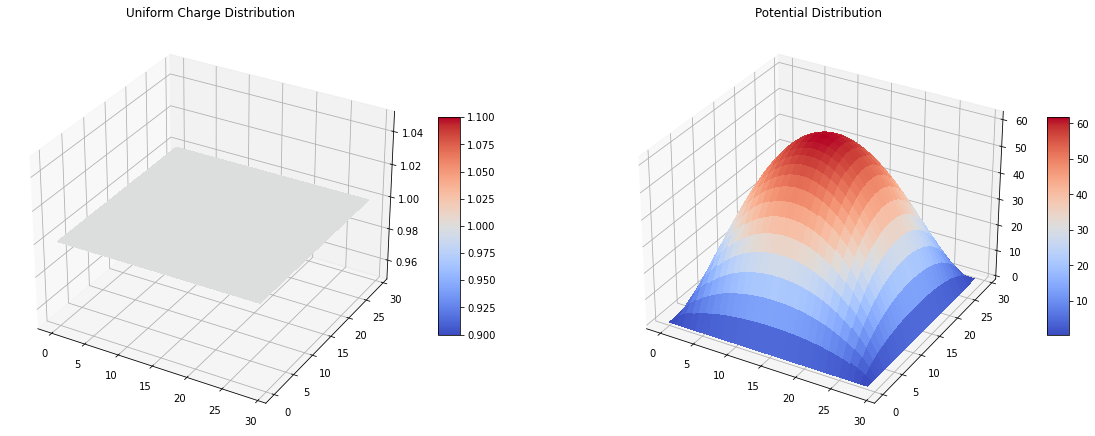

In [17]:
fig_sor=plt.figure(figsize=(20,8))
ax1_sor = fig_sor.add_subplot(1, 2, 1, projection='3d')
X1 = np.arange(0,N)
Y1 = np.arange(0,N)
X1, Y1 = np.meshgrid(X1, Y1)
Z1_sor = charge_density[0:N,0:N]
surf1_sor = ax1_sor.plot_surface(X1, Y1, Z1_sor, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1_sor.set_title('Uniform Charge Distribution')
fig_sor.colorbar(surf1_sor, shrink=0.5, aspect=10)

ax3_sor = fig_sor.add_subplot(1, 2, 2, projection='3d')
Z3_sor = potential_sor[0:N,0:N]
surf3_sor = ax3_sor.plot_surface(X1, Y1, Z3_sor, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3_sor.set_title('Potential Distribution')
fig_sor.colorbar(surf3_sor, shrink=0.5, aspect=10)

<font  face=Times color=darkblue size=3> With the same bound, we can see faster convergence.

## Results of different charge density

<font  face=Times color=darkblue size=3>When we introduce the methods above, we always use the uniform charge distribution. Now we are gonna to change the charge distribution and see the corresponding different potential distributions. As the results are the same for the methods, we use SOR for example here.

In [18]:
N=20  ### use even numbers for convenience!
#reset N including the boundary
potential_initial=np.zeros((N,N)) #this includes boundary=0

In [19]:
def sor_here(bound_here):
    iterations=0
    potential_new=copy.deepcopy(potential_initial)
    rhere=np.cos(np.pi/(N-2))
    w_opt=2/(1+np.sqrt(1-rhere**2))
    #print(w_opt)
    while True:
        iterations+=1
        max_delta=0
        for i in range(1,N-1):
            for j in range(1,N-1): # simulate all N-2*N-2 sites using discretized poisson equation, no simulation for boundary 
                left_index=i-h
                right_index=i+h
                up_index=j+h
                down_index=j-h
                potential_point_new=(1-w_opt)*potential_new[i,j]+w_opt*((1/(2*d))*(potential_new[i,up_index]
                                                                                   +potential_new[i,down_index]
                                                                                   +potential_new[right_index,j]
                                              +potential_new[left_index,j])+(h**2/(2*d*epsilon))*charge_density[i,j]) #new point
                max_delta=max(max_delta,np.abs(potential_new[i,j]-potential_point_new))  #delta_phi
                potential_new[i,j]=potential_point_new #update point
        if max_delta <= bound_here:
            break
        #print(iterations,max_delta)
    return potential_new

In [20]:
charge_density=np.zeros((N,N)) #  1.uniform charge on two rows in the middle
for i in range(1,N-1):
    charge_density[int(N/2),i]=1
    charge_density[int(N/2)-1,i]=1
potential_1=sor_here(0.00001)
charge_1=copy.deepcopy(charge_density)
charge_density=np.zeros((N,N)) # 2. put four point charge in the middle of the square lattice
charge_density[int(N/2),int(N/2)]=charge_density[int(N/2)-1,int(N/2)]=charge_density[int(N/2),int(N/2)-1]=charge_density[int(N/2)-1,int(N/2)-1]=1
potential_2=sor_here(0.00001)
charge_2=copy.deepcopy(charge_density)

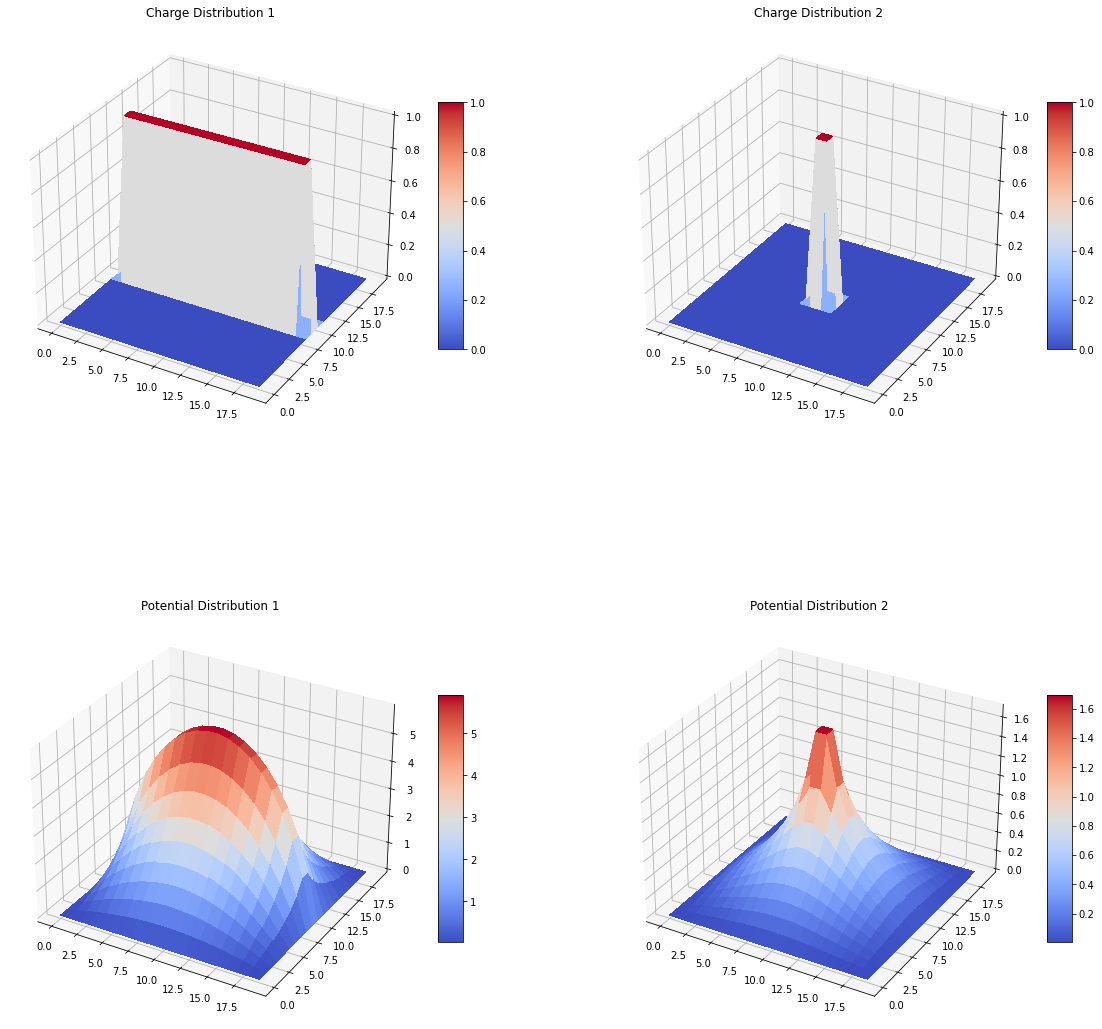

In [21]:

fig=plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')

X1 = np.arange(0,N)
Y1 = np.arange(0,N)
X1, Y1 = np.meshgrid(X1, Y1)
Z1 = charge_1[0:N,0:N]
surf1 = ax1.plot_surface(X1, Y1, Z1, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1.set_title('Charge Distribution 1')
fig.colorbar(surf1, shrink=0.5, aspect=10)
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
Z2 = charge_2[0:N,0:N]
surf2 = ax2.plot_surface(X1, Y1, Z2, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax2.set_title('Charge Distribution 2')
fig.colorbar(surf2, shrink=0.5, aspect=10)

ax3 = fig.add_subplot(2, 2, 3, projection='3d')
Z3 = potential_1[0:N,0:N]
surf3 = ax3.plot_surface(X1, Y1, Z3, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax3.set_title('Potential Distribution 1')
fig.colorbar(surf3, shrink=0.5, aspect=10)

ax4 = fig.add_subplot(2, 2, 4, projection='3d')
Z4 = potential_2[0:N,0:N]
surf4 = ax4.plot_surface(X1, Y1, Z4, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax4.set_title('Potential Distribution 2')
fig.colorbar(surf4, shrink=0.5, aspect=10)

<font  face=Times color=darkblue size=3> Now we can see clearly how different charge densities result in different electric field distribution.